In [ ]:
# pip install -U sentence-transformers

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from IPython.display import  clear_output
import time
import PyPDF2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-3B-Instruct"

# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4",  # Normalized float 4-bit (recommended)
    bnb_4bit_compute_dtype=torch.float16,  
    bnb_4bit_use_double_quant=True  # Improves performance by applying second quantization
)

model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    device_map=device,
)

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.generation_config.pad_token_id = 128001

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
pdf_path = 'bhagavad-gita-in-english-source-file.pdf'
pdf_reader = PyPDF2.PdfReader(pdf_path)
# Get total number of pages
num_pages = len(pdf_reader.pages)
print(f"Processing PDF with {num_pages} pages...")

full_text = []

for page_num in range(4,num_pages-1):
    page = pdf_reader.pages[page_num]
    text = page.extract_text()
    full_text.append(text)

full_text = '\n'.join(full_text)


Processing PDF with 53 pages...


In [3]:
tokenized_text = tokenizer(full_text).input_ids

In [4]:
chunk_size = 100
chunk_overlap = 20

chunk_list = []

for i in tqdm(range(0, len(tokenized_text), chunk_size - chunk_overlap)):
    print(i,i+chunk_size)
    chunk = tokenized_text[i:i+chunk_size]
    decoded_text = tokenizer.decode(chunk, skip_special_tokens=True)
    chunk_list.append(decoded_text)
    # break



100%|██████████| 431/431 [00:00<00:00, 3676.66it/s]

0 100
80 180
160 260
240 340
320 420
400 500
480 580
560 660
640 740
720 820
800 900
880 980
960 1060
1040 1140
1120 1220
1200 1300
1280 1380
1360 1460
1440 1540
1520 1620
1600 1700
1680 1780
1760 1860
1840 1940
1920 2020
2000 2100
2080 2180
2160 2260
2240 2340
2320 2420
2400 2500
2480 2580
2560 2660
2640 2740
2720 2820
2800 2900
2880 2980
2960 3060
3040 3140
3120 3220
3200 3300
3280 3380
3360 3460
3440 3540
3520 3620
3600 3700
3680 3780
3760 3860
3840 3940
3920 4020
4000 4100
4080 4180
4160 4260
4240 4340
4320 4420
4400 4500
4480 4580
4560 4660
4640 4740
4720 4820
4800 4900
4880 4980
4960 5060
5040 5140
5120 5220
5200 5300
5280 5380
5360 5460
5440 5540
5520 5620
5600 5700
5680 5780
5760 5860
5840 5940
5920 6020
6000 6100
6080 6180
6160 6260
6240 6340
6320 6420
6400 6500
6480 6580
6560 6660
6640 6740
6720 6820
6800 6900
6880 6980
6960 7060
7040 7140
7120 7220
7200 7300
7280 7380
7360 7460
7440 7540
7520 7620
7600 7700
7680 7780
7760 7860
7840 7940
7920 8020
8000 8100
8080 8180
8160 826

In [5]:
i=280
chunk = tokenized_text[i:i+chunk_size]
decoded_text = tokenizer.decode(chunk, skip_special_tokens=True)
print(decoded_text)

panishads and Vedanta. The prime message 
of the Gita is : The ultimate purpose of life is to realize one’s essen-
tial nature and become one with the Supreme Self within  all of us. 
It assures spiritual progress for all humans, and ho w to be one with 
the Supreme. Its teachings are profound, universal, uplifting, and 
sublime.  
The ignorance of metaphysical  or Spiritual  knowledge —not 
knowing our real identity —is


# Cleaning the text

In [6]:

def clean_text_with_llm(text):
    conversation = [
        {"role": "system", "content": f'''You are a text editor that refines extracted text while preserving its meaning. Your task is to clean up the text by:
    1. Removing any unnecessary line breaks or splits between words.
    2. Removing page numbers, footer text, and any references to links or URLs.
    3. Stripping out any other irrelevant or redundant information (e.g., citation references, headers, footers).
    4. Retaining the original content and ensuring that the flow and meaning of the text are unchanged.

    Do not add new content or make any changes that alter the overall meaning. The goal is to make the text readable, concise, and free of formatting errors typical of scanned PDFs or text extraction processes.
    Start your response immediately after the prompt do not add things like "Here is the cleaned-up text:"'''},
        {"role": "user", "content": f'''{text}'''},
    ]
    # 
    prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)


    with torch.no_grad():
        output = model.generate(**inputs,
                                do_sample=True,
                                max_new_tokens=128)


    processed_text = tokenizer.decode(output[0][len(inputs.input_ids[0])+3:], skip_special_tokens=True)

    return processed_text

In [7]:
print(decoded_text,'\n')
print(clean_text_with_llm(decoded_text).strip())

panishads and Vedanta. The prime message 
of the Gita is : The ultimate purpose of life is to realize one’s essen-
tial nature and become one with the Supreme Self within  all of us. 
It assures spiritual progress for all humans, and ho w to be one with 
the Supreme. Its teachings are profound, universal, uplifting, and 
sublime.  
The ignorance of metaphysical  or Spiritual  knowledge —not 
knowing our real identity —is 

The prime message of the Gita is that the ultimate purpose of life is to realize one's essential nature and become one with the Supreme Self within all of us. It assures spiritual progress for all humans and shows how to be one with the Supreme. Its teachings are profound, universal, uplifting, and sublime. The ignorance of metaphysical or spiritual knowledge, not knowing our real identity, is the root of all human suffering.


In [8]:
cleaned_text=[]
for chunk in tqdm(chunk_list,leave=True):
    cleaned_text.append(clean_text_with_llm(chunk).strip())

  0%|          | 1/431 [00:03<22:17,  3.11s/it]


KeyboardInterrupt: 

In [6]:
import pickle

# Open a file in write-binary mode and save the list
# with open("cleaned_text.pkl", "wb") as f:
#     pickle.dump(cleaned_text, f)
    
with open("cleaned_text.pkl", "rb") as f:
    cleaned_text = pickle.load(f)

print("Loaded list:", cleaned_text)

Loaded list: ['BHAGAVAD -GITA in ENGLISH  \nAuthor: Sage Veda Vy asa  \nTranslat ed in English : Ramananda Prasad, Ph.D.  \nLanguage Editor s: Needed  \nContact: rprasad@gita -society.com  \n*****  \n“Let noble thoughts come to us from everywhere”    \n(The Vedas)  \n \nINTRODUCTION  \nThe Bhagavad -Gita is a doctrine of universal truth  and a book of moral and philosophical teachings.', 'Bhagavad -Gita is a doctrine of universal truth and a book of moral and spiritual growth. Its message is sublime and non-secular. It deals with the most sacred metaphysical science. It imparts the knowledge of the Self and answers two universal questions: Who am I, and how can I lead a happy and peaceful life in this world full of dualities and dilemmas.', 'timeless book of wisdom \nthat inspired Thoreau, Emerson, Einstein, Oppenheimer, Gandhi and many others. \nThe Bhagavad-Gita teaches us how to equip ourselves for the battle of life. A repeated study with faith purifies our psyche and guides us to 

# Creating Vector database

In [7]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

## Visualize the sentence-vecor space

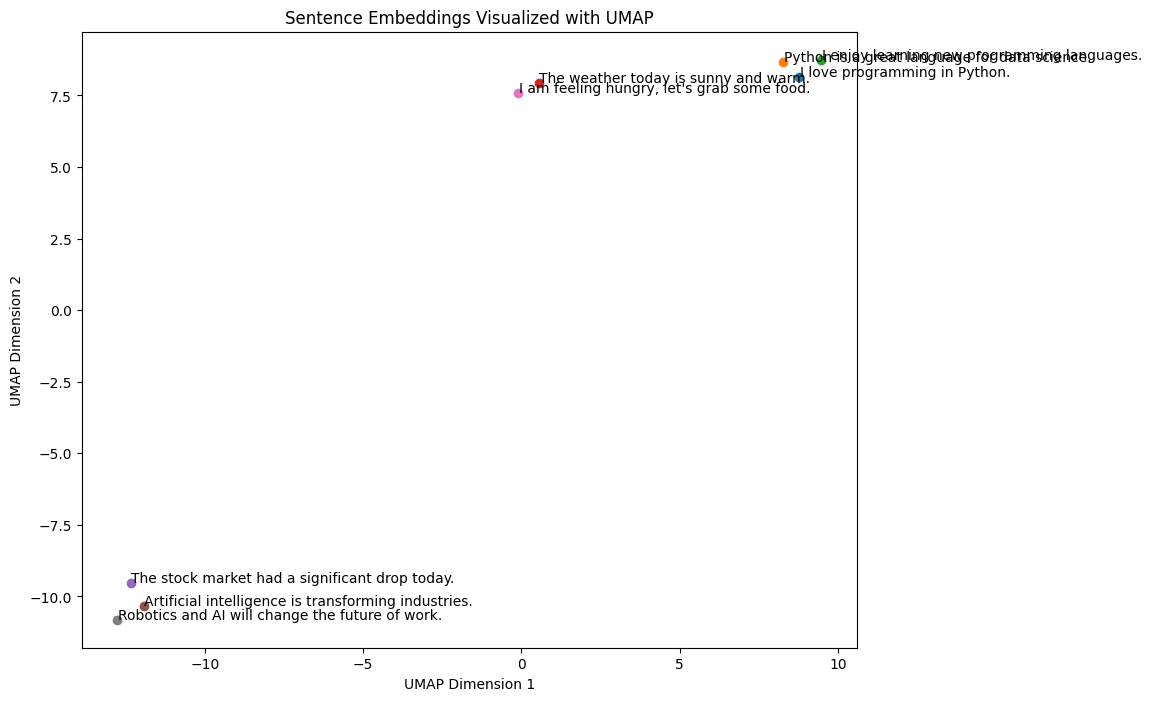

In [8]:
# 2. Example sentences
sentences = [
    "I love programming in Python.",
    "Python is a great language for data science.",
    "I enjoy learning new programming languages.",
    "The weather today is sunny and warm.",
    "The stock market had a significant drop today.",
    "Artificial intelligence is transforming industries.",
    "I am feeling hungry, let's grab some food.",
    "Robotics and AI will change the future of work."
]

# sentences = [cleaned_text[1],cleaned_text[2],cleaned_text[50],cleaned_text[51],cleaned_text[200]]

# 3. Get sentence embeddings
embeddings = embedding_model.encode(sentences)

# 4. Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_neighbors=2, min_dist=0.3, metric='cosine')
umap_embeddings = umap_model.fit_transform(embeddings)

# 5. Plotting the results
plt.figure(figsize=(10, 8))

# Plot each sentence with its respective label
for i, sentence in enumerate(sentences):
    plt.scatter(umap_embeddings[i, 0], umap_embeddings[i, 1])
    plt.text(umap_embeddings[i, 0] + 0.02, umap_embeddings[i, 1] + 0.02, sentence, fontsize=10)

plt.title('Sentence Embeddings Visualized with UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [9]:
# 2. Calculate embeddings by calling model.encode()
embeddings = embedding_model.encode(cleaned_text, convert_to_tensor=True)
print(embeddings.shape)
torch.save(embeddings, "vector_embeddings.pt")

torch.Size([431, 384])


Is there an afterlife? What happens when we die?
I often feel lost in life. How do I find my true purpose?
Why does God allow suffering and evil in the world?
What is the role of prayer, and does it really work?

In [15]:
query = 'What is the role of prayer, and does it really work?'

query_encoded = embedding_model.encode([query], convert_to_tensor=True)
similarities = embedding_model.similarity(query_encoded, embeddings)
scores, top_5_indices = torch.topk(similarities[0], k=5)
print(scores, top_5_indices)

# Step 6: Display results
print("Top 5 similar chunks:")
for idx in top_5_indices:
    print(f"Score: {similarities[0][idx]:.4f} | Chunk: {cleaned_text[idx]} \n")

tensor([0.4407, 0.4376, 0.4317, 0.4246, 0.4068], device='cuda:0') tensor([304, 119, 282, 105,  95], device='cuda:0')
Top 5 similar chunks:
Score: 0.4407 | Chunk: by met-
aphysical knowledge or by Karma -yoga. (13.24)  
The faith alone can lead to Nirvana 
Others, however, do not know the yoga of meditation, 
knowledge, and work; but they perform deity worship with faith, as 
mentioned in the scriptures by the saints and sages. They also transcend death by virtue of their firm faith in what they have heard. 

Score: 0.4376 | Chunk: Karma yoga. A sage equipped with karma yoga quickly attains God. (5.06) A karma yogi whose mind is pure, whose mind and senses are under control, and who sees one and the same eternal being in all beings, is not bound by karma though intensely engaged in work. (5.07) A karma yogi works for God only. The wise one who knows the truth. 

Score: 0.4317 | Chunk: working for Me as an instrument, just to serve and please Me, without selfish motives. (12.10) If you a

In [16]:
CONTEXT_TEXT = '\n'.join([cleaned_text[idx] for idx in top_5_indices if similarities[0][idx]>0])

In [17]:

conversation = [
    {"role": "system", "content": f'''You are a compassionate guide. 
     You answer questions based only on the given context of Gita and do not add any extra information.
     If the question asked by the user is not raleted to the context, you say 'this is not relate dto bhagabat gita'. 
     Your goal is to first interprete the writtings of gita in the given context and then try your best to relate to user's query.
     Answer in simple english that a 15 year old can undrestand using your interpretation of the given text. 
     CONTEXT : {CONTEXT_TEXT}. 
     Answer should not be longer than 100 words. Do not use markdown format'''},
    {"role": "user", "content": f'''{query}. '''},
]
# 
prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt").to(device)


with torch.no_grad():
    output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=256
    )


processed_text = tokenizer.decode(output[0][len(inputs.input_ids[0])+3:], skip_special_tokens=True)

print(processed_text)



According to the Bhagavad Gita, prayer is a way to worship and connect with the divine. It's mentioned that with whatever motive people worship, the Lord fulfills their desires accordingly. This means that prayer can bring success and fulfillment, but it depends on the motive behind it. If done with a selfish motive, it may not be effective, but if done with a pure and selfless motive, it can lead to spiritual growth and salvation. So, prayer can work if done with the right intention.


In [13]:
from kokoro import KPipeline
from IPython.display import display, Audio
import soundfile as sf

tts_pipeline = KPipeline(lang_code='a') # <= make sure lang_code matches voice

c:\Users\User\miniconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
c:\Users\User\miniconda3\envs\torch_env\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [14]:
generator = tts_pipeline(processed_text,voice='af_bella')

audios = []
for i, (gs, ps, audio) in enumerate(generator):
    audios.append(audio)
    
AUDIO = torch.cat(audios, dim=0)

display(Audio(data=AUDIO, rate=24000))

af_bella.pt:   0%|          | 0.00/523k [00:00<?, ?B/s]

# Putting it all together

In [54]:
def RAG_GITA(query):
    query_encoded = embedding_model.encode([query], convert_to_tensor=True)
    similarities = embedding_model.similarity(query_encoded, embeddings)
    scores, top_5_indices = torch.topk(similarities[0], k=5)
    print(scores, top_5_indices)

    CONTEXT_TEXT = '\n'.join([cleaned_text[idx] for idx in top_5_indices if similarities[0][idx]>0])

    conversation = [
        {"role": "system", "content": f'''You are a compassionate guide. 
        You answer questions based only on the given context of Gita and do not add any extra information. 
        Your goal is to first interprete the writtings of gita in the given context and then try your best to relate to user's query.
        Answer in simple english that a 15 year old can undrestand using your interpretation of the given text. 
        CONTEXT : {CONTEXT_TEXT}. 
        Answer should not be longer than 100 words. Do not use markdown format'''},
        {"role": "user", "content": f'''{query}. '''},
    ]
    # 
    prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)


    with torch.no_grad():
        output = model.generate(
            **inputs,
            do_sample=True,
            max_new_tokens=256
        )


    processed_text = tokenizer.decode(output[0][len(inputs.input_ids[0])+3:], skip_special_tokens=True)

    generator = tts_pipeline(processed_text,voice='af_bella')

    audios = []
    for i, (gs, ps, audio) in enumerate(generator):
        audios.append(audio)
        
    AUDIO = torch.cat(audios, dim=0)
    
    return AUDIO

query = '''what is better, islam or hinduism'''
AUDIO = RAG_GITA(query)
display(Audio(data=AUDIO, rate=24000))

tensor([0.5221, 0.4332, 0.4314, 0.4198, 0.4119], device='cuda:0') tensor([283, 112, 117, 108, 396], device='cuda:0')
